# Disk Initial Conditions Parameter Sweep

This notebook explores the parameter space for disk winds initialization, solving for $\alpha_{SS}$ given:
- $\dot{M}$: Accretion rate
- $M_{disk}$: Disk mass
- $R_d$: Characteristic disk radius
- $\psi$: Wind parameter

We create color-mesh plots showing the resulting $\alpha_{SS}$ values across parameter space.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sys

from DiscEvolution.constants import *
from DiscEvolution.grid import Grid
from DiscEvolution.star import SimpleStar
from DiscEvolution.eos import IrradiatedEOS
from DiscEvolution.disc import AccretionDisc
from DiscEvolution.viscous_evolution import HybridWindModel
from DiscEvolution.opacity import Tazzari2016

plt.rcParams.update({'font.size': 12})

## Define Disk Initialization Function

Based on the 'winds-alpha' case from run_model_discchem_stream.py

In [2]:
def solve_alpha_winds(Mdot, Mdisk, Rd, psi, e_rad=0.9, gamma=1, nr=500, rmin=0.1, rmax=1000, 
                      alpha_init=1e-3, max_iter=100, Tmax=1500.):
    """
    Solve for alpha_SS given disk parameters with winds.
    
    Parameters:
    -----------
    Mdot : float
        Accretion rate [Msun/yr]
    Mdisk : float
        Disk mass [Msun]
    Rd : float
        Characteristic radius [AU]
    psi : float
        Wind parameter
    e_rad : float
        Radiative efficiency (default=0.9)
    gamma : float
        Surface density power law index (default=1)
    nr : int
        Number of radial grid points (default=500)
    alpha_init : float
        Initial guess for alpha (default=1e-3)
    max_iter : int
        Maximum iterations (default=100)
    Tmax : float
        Maximum temperature [K] (default=1500)
    
    Returns:
    --------
    alpha_SS : float
        Shakura-Sunyaev alpha parameter
    converged : bool
        Whether the solution converged
    """
    # Create grid, star, and opacity
    grid = Grid(rmin, rmax, nr, spacing='natural')
    star = SimpleStar(M=1.0, R=2.5, T_eff=4000)
    kappa = Tazzari2016()
    
    # Wind model parameters
    lambda_DW = 1/(2*(1 - e_rad)*(3/psi + 1)) + 1
    R = grid.Rc
    alpha = alpha_init
    alpha_SS = alpha/(1 + psi)
    
    # Initial Sigma profile
    Mdisk_cgs = Mdisk * Msun
    Sigma_d = Mdisk_cgs/(2 * np.pi * (Rd*AU)**2)
    xi = 0
    Sigma = Sigma_d * (R/Rd)**(xi - gamma) * np.exp(-(R/Rd)**(2 - gamma))
    
    # Define gas model
    gas_temp = HybridWindModel(psi, lambda_DW)
    
    # Scale Sigma by current Mtot
    disc = AccretionDisc(grid, star, eos=None, Sigma=Sigma)
    Mtot = disc.Mtot()
    Sigma[:] *= Mdisk_cgs / Mtot
    
    converged = False
    for i in range(max_iter):
        # Create EOS
        eos = IrradiatedEOS(star, alpha_t=alpha_SS, kappa=kappa, psi=psi, e_rad=e_rad, Tmax=Tmax)
        eos.set_grid(grid)
        eos.update(0, Sigma)
        
        # Define disc
        disc = AccretionDisc(grid, star, eos, Sigma)
        
        # Find current Mdot
        vr = gas_temp.viscous_velocity(disc, Sigma)
        Mdot_actual = disc.Mdot(vr)[0]  # solar masses per year
        
        # Scale alpha by Mdot
        alpha_new = alpha * Mdot / Mdot_actual
        
        # Check convergence
        if np.abs(alpha_new - alpha) / alpha < 1e-4:
            converged = True
            break
            
        alpha = 0.5 * (alpha + alpha_new)  # damping
        alpha_SS = alpha/(1 + psi)
    
    return alpha_SS, converged

## Parameter Space Setup

In [3]:
# Define parameter ranges (20 log bins each)
n_bins = 20

Mdot_range = np.logspace(-9, -6, n_bins)  # Msun/yr
Mdisk_range = np.logspace(-2, np.log10(0.2), n_bins)  # Msun
Rd_range = np.logspace(1, 2, n_bins)  # AU (10 to 100 AU)
psi_range = np.logspace(-2, 2, n_bins)  # dimensionless

print(f"Mdot range: {Mdot_range.min():.2e} to {Mdot_range.max():.2e} Msun/yr")
print(f"Mdisk range: {Mdisk_range.min():.3f} to {Mdisk_range.max():.3f} Msun")
print(f"Rd range: {Rd_range.min():.1f} to {Rd_range.max():.1f} AU")
print(f"psi range: {psi_range.min():.2e} to {psi_range.max():.2e}")

Mdot range: 1.00e-09 to 1.00e-06 Msun/yr
Mdisk range: 0.010 to 0.200 Msun
Rd range: 10.0 to 100.0 AU
psi range: 1.00e-02 to 1.00e+02


## Run Parameter Sweeps

We'll compute alpha_SS for three 2D parameter spaces, fixing the other parameters at fiducial values.

In [10]:
# Fiducial values
Mdot_fid = 1e-7  # Msun/yr
Mdisk_fid = 0.1  # Msun
Rd_fid = 50.0    # AU
psi_fid = 1   # dimensionless

print("Starting parameter sweeps...")
print(f"Fiducial values: Mdot={Mdot_fid:.2e}, Mdisk={Mdisk_fid:.2f}, Rd={Rd_fid:.1f}, psi={psi_fid:.3f}")

Starting parameter sweeps...
Fiducial values: Mdot=1.00e-07, Mdisk=0.10, Rd=50.0, psi=1.000


### Sweep 1: Mdot vs Mass (fix Rd, psi)

In [11]:
alpha_grid_1 = np.zeros((n_bins, n_bins))
converged_1 = np.zeros((n_bins, n_bins), dtype=bool)

print("\nSweep 1: Mdot vs Mass")
for i, mdot in enumerate(Mdot_range):
    for j, mdisk in enumerate(Mdisk_range):
        alpha_ss, conv = solve_alpha_winds(mdot, mdisk, Rd_fid, psi_fid)
        alpha_grid_1[j, i] = alpha_ss
        converged_1[j, i] = conv
    print(f"  Progress: {i+1}/{n_bins}", end='\r')

print(f"\nConverged: {converged_1.sum()}/{converged_1.size} cases")


Sweep 1: Mdot vs Mass
  Progress: 20/20
Converged: 400/400 cases


### Sweep 2: Mass vs Size (fix Mdot, psi)

In [12]:
alpha_grid_2 = np.zeros((n_bins, n_bins))
converged_2 = np.zeros((n_bins, n_bins), dtype=bool)

print("\nSweep 2: Mass vs Size")
for i, rd in enumerate(Rd_range):
    for j, mdisk in enumerate(Mdisk_range):
        alpha_ss, conv = solve_alpha_winds(Mdot_fid, mdisk, rd, psi_fid)
        alpha_grid_2[j, i] = alpha_ss
        converged_2[j, i] = conv
    print(f"  Progress: {i+1}/{n_bins}", end='\r')

print(f"\nConverged: {converged_2.sum()}/{converged_2.size} cases")


Sweep 2: Mass vs Size
  Progress: 20/20
Converged: 400/400 cases


### Sweep 3: psi vs Mdot (fix Mass, Rd)

In [13]:
alpha_grid_3 = np.zeros((n_bins, n_bins))
converged_3 = np.zeros((n_bins, n_bins), dtype=bool)

print("\nSweep 3: psi vs Mdot")
for i, mdot in enumerate(Mdot_range):
    for j, psi in enumerate(psi_range):
        alpha_ss, conv = solve_alpha_winds(mdot, Mdisk_fid, Rd_fid, psi)
        alpha_grid_3[j, i] = alpha_ss
        converged_3[j, i] = conv
    print(f"  Progress: {i+1}/{n_bins}", end='\r')

print(f"\nConverged: {converged_3.sum()}/{converged_3.size} cases")


Sweep 3: psi vs Mdot
  Progress: 20/20
Converged: 400/400 cases


## Create Plots

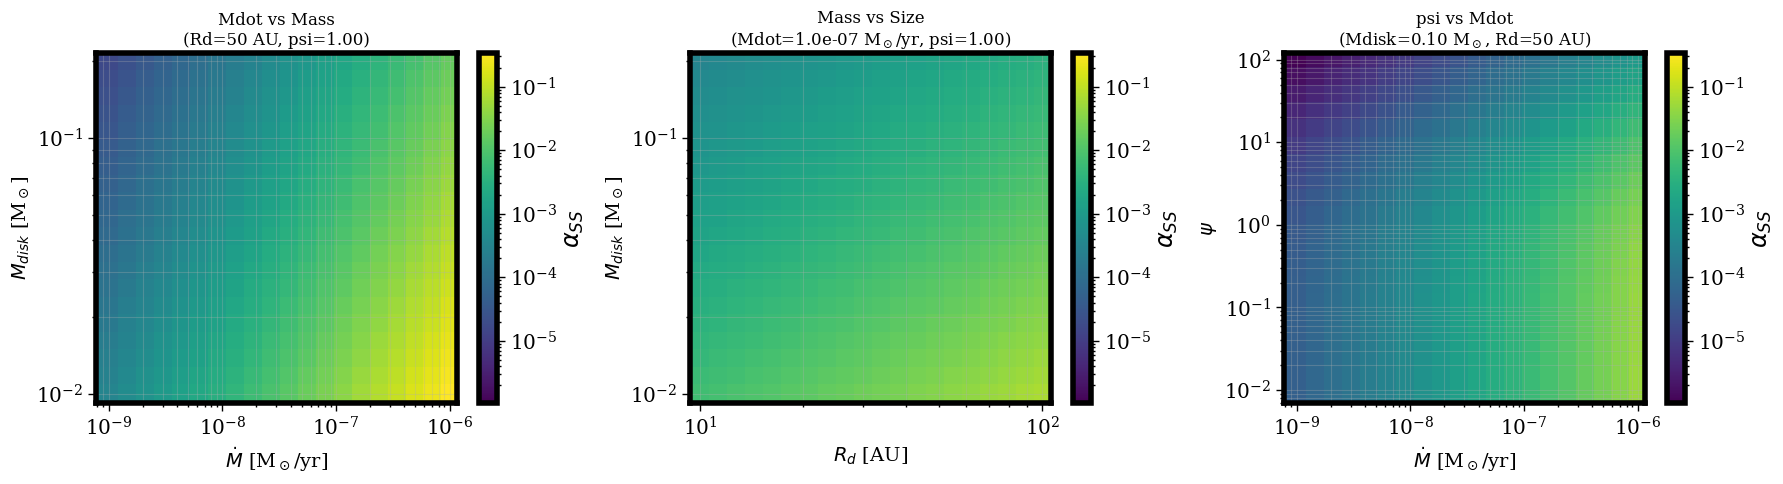


Plot saved as 'disk_IC_parameter_sweep.png'


In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Mask non-converged points
alpha_1_masked = np.ma.masked_where(~converged_1, alpha_grid_1)
alpha_2_masked = np.ma.masked_where(~converged_2, alpha_grid_2)
alpha_3_masked = np.ma.masked_where(~converged_3, alpha_grid_3)

# Determine common colorbar limits
vmin = min(alpha_1_masked.min(), alpha_2_masked.min(), alpha_3_masked.min())
vmax = max(alpha_1_masked.max(), alpha_2_masked.max(), alpha_3_masked.max())

# Plot 1: Mdot vs Mass
ax = axes[0]
im1 = ax.pcolormesh(Mdot_range, Mdisk_range, alpha_1_masked, 
                     shading='auto', cmap='viridis', norm=LogNorm(vmin=vmin, vmax=vmax))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\dot{M}$ [M$_\odot$/yr]', fontsize=14)
ax.set_ylabel(r'$M_{disk}$ [M$_\odot$]', fontsize=14)
ax.set_title(f'Mdot vs Mass\n(Rd={Rd_fid:.0f} AU, psi={psi_fid:.2f})', fontsize=12)
plt.colorbar(im1, ax=ax, label=r'$\alpha_{SS}$')
ax.grid(True, alpha=0.3, which='both')

# Plot 2: Mass vs Size
ax = axes[1]
im2 = ax.pcolormesh(Rd_range, Mdisk_range, alpha_2_masked, 
                     shading='auto', cmap='viridis', norm=LogNorm(vmin=vmin, vmax=vmax))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$R_d$ [AU]', fontsize=14)
ax.set_ylabel(r'$M_{disk}$ [M$_\odot$]', fontsize=14)
ax.set_title(f'Mass vs Size\n(Mdot={Mdot_fid:.1e} M$_\odot$/yr, psi={psi_fid:.2f})', fontsize=12)
plt.colorbar(im2, ax=ax, label=r'$\alpha_{SS}$')
ax.grid(True, alpha=0.3, which='both')

# Plot 3: psi vs Mdot
ax = axes[2]
im3 = ax.pcolormesh(Mdot_range, psi_range, alpha_3_masked, 
                     shading='auto', cmap='viridis', norm=LogNorm(vmin=vmin, vmax=vmax))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\dot{M}$ [M$_\odot$/yr]', fontsize=14)
ax.set_ylabel(r'$\psi$', fontsize=14)
ax.set_title(f'psi vs Mdot\n(Mdisk={Mdisk_fid:.2f} M$_\odot$, Rd={Rd_fid:.0f} AU)', fontsize=12)
plt.colorbar(im3, ax=ax, label=r'$\alpha_{SS}$')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('disk_IC_parameter_sweep.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPlot saved as 'disk_IC_parameter_sweep.png'")

## Summary Statistics

In [9]:
print("\n=== Summary Statistics ===")
print(f"\nSweep 1 (Mdot vs Mass):")
print(f"  alpha_SS range: {alpha_1_masked.min():.3e} to {alpha_1_masked.max():.3e}")
print(f"  Converged: {converged_1.sum()}/{converged_1.size}")

print(f"\nSweep 2 (Mass vs Size):")
print(f"  alpha_SS range: {alpha_2_masked.min():.3e} to {alpha_2_masked.max():.3e}")
print(f"  Converged: {converged_2.sum()}/{converged_2.size}")

print(f"\nSweep 3 (psi vs Mdot):")
print(f"  alpha_SS range: {alpha_3_masked.min():.3e} to {alpha_3_masked.max():.3e}")
print(f"  Converged: {converged_3.sum()}/{converged_3.size}")


=== Summary Statistics ===

Sweep 1 (Mdot vs Mass):
  alpha_SS range: 2.443e-05 to 4.886e-01
  Converged: 400/400

Sweep 2 (Mass vs Size):
  alpha_SS range: 1.487e-05 to 2.926e-03
  Converged: 400/400

Sweep 3 (psi vs Mdot):
  alpha_SS range: 1.036e-06 to 4.886e-02
  Converged: 400/400
